## Generating Dataset

In [234]:
import random
from collections import Counter, defaultdict
import numpy as np


def generate_correct_sample(max_length=20, min_length=1):
    n = random.randint(np.ceil(min_length / 3), np.ceil(max_length / 3))
    return ('a' * n) + ('b' * n) + ('c' * n)

def create_dataset_train(max_length=20, min_length=1):
    dataset = []
    
    # Generate all potential correct samples
    for n in range(min_length, max_length + 1):
       dataset.append(('a' * n) + ('b' * n) + ('c' * n))
       
    num_true_labels = len(dataset)
    # Generate counterexamples with slight variations
    count_variations = [0,0,0]
    while len(dataset) < 20 * num_true_labels:
        probabilities = [0.7, 0.15, 0.15]
        variation_type = np.random.choice([0, 1, 2], p=probabilities)
        # Count the number of variations of each type
        if variation_type == 0:
            # Generate counterexample by n randomly selected characters
            n = random.randint(min_length, max_length)
            chars = random.choices(['a', 'b', 'c'], k=n)
            counter_example = ''.join(chars)
        elif variation_type == 1:
            # Remove one character from the sample
            idx = random.randint(0, len(dataset) - 1)
            counter_example = dataset[idx][:-1]
        else:
            # Add one character to the sample
            idx = random.randint(0, len(dataset) - 1)
            counter_example = dataset[idx] + random.choice(['a', 'b', 'c'])
            
        # Check whether counter example isnt randomly a correct sample
        counter = Counter(counter_example)
        if counter['a'] == counter['b'] == counter['c']:
            continue
        
        # Check if the counterexample is not too long
        if len(counter_example) < max_length + 1 and len(counter_example) > min_length - 1:
            count_variations[variation_type] += 1
            dataset.append(counter_example)
        
    return dataset


def create_dataset(num_samples, max_length=20, min_length=1):
    dataset = []
    
    # Generate all potential correct samples
    correct_samples = []
    for n in range(min_length, max_length + 1):
        correct_samples.append(('a' * n) + ('b' * n) + ('c' * n))
    
    # Generate samples of the form a^n b^n c^n
    while len(dataset) < num_samples:
        sample = generate_correct_sample(max_length, min_length)
        if len(sample) < max_length + 1 and len(sample) > min_length - 1:
            dataset.append((sample, 1))
        
    # Generate counterexamples with slight variations
    count_variations = [0,0,0]
    while len(dataset) < 2 * num_samples:
        probabilities = [0.7, 0.15, 0.15]
        variation_type = np.random.choice([0, 1, 2], p=probabilities)
        # Count the number of variations of each type
        if variation_type == 0:
            # Generate counterexample by n randomly selected characters
            n = random.randint(min_length, max_length)
            chars = random.choices(['a', 'b', 'c'], k=n)
            counter_example = ''.join(chars)
        elif variation_type == 1:
            # Remove one character from the sample
            sample = generate_correct_sample(max_length, min_length)
            idx = random.randint(0, len(sample) - 1)
            counter_example = sample[:idx] + sample[idx+1:]
        else:
            # Add one character to the sample
            sample = generate_correct_sample(max_length, min_length)
            idx = random.randint(0, len(sample) - 1)
            counter_example = sample[:idx] + random.choice(['a', 'b', 'c']) + sample[idx:]
            
        # Check whether counter example isnt randomly a correct sample
        counter = Counter(counter_example)
        if counter['a'] == counter['b'] == counter['c']:
            continue
        
        # Check if the counterexample is not too long
        if len(counter_example) < max_length + 1 and len(counter_example) > min_length - 1:
            count_variations[variation_type] += 1
            dataset.append((counter_example, 0))  # Append the counterexample along with its label 0
       
    # Shuffle the dataset 
    random.shuffle(dataset)
    print("Dataset created with {} samples.".format(len(dataset)))
    print("Variation types: ", count_variations)
    assert np.sum(count_variations) == len(dataset) / 2
    return dataset
        

# Example usage:
num_samples = 500
max_length = 20
min_length = 1
dataset = create_dataset(num_samples, max_length, min_length)
print(dataset[:5])


test_dataset_str = create_dataset(500, 100, 21)
print(test_dataset_str[:5])



Dataset created with 1000 samples.
Variation types:  [367, 63, 70]
[('bcccccba', 0), ('bacca', 0), ('acbcc', 0), ('aaaaaabbbbbbcccccc', 1), ('aaabbbccc', 1)]
Dataset created with 1000 samples.
Variation types:  [366, 61, 73]
[('abccbacccbccaababbabaaacbcbcabbbabcbaabbcabaacbbb', 0), ('aaaaaaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbcccccccccccccccccccc', 1), ('aaaaaaaaaaaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbbbbbbccccccccccccccccccccccccc', 1), ('aaaaaaaaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbbbcccccccccccccccccccccc', 1), ('aaaaaaaaaabbbbbbbbbbccccccccc', 0)]


## Preprocessing

In [235]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


# define char to index mapping
char_to_index = {'a': 0, 'b': 1, 'c': 2, 'p': 3}

def char_to_one_hot(char, num_classes=3):
    index = char_to_index[char]
    one_hot = np.zeros(num_classes)
    one_hot[index] = 1
    return one_hot

def string_to_tensor(string, padding_length=0, add_padding = False):
    if add_padding:
        tensor = np.array([char_to_one_hot(char, num_classes=4) for char in string]
                          + [char_to_one_hot('p', num_classes=4)] * (padding_length - len(string)))
    else:
        tensor = np.array([char_to_one_hot(char) for char in string])
    return torch.tensor(tensor, dtype=torch.float32)

class GrammarDataset(Dataset):
    def __init__(self, data, padding_length=0, add_padding = False):
        self.data = data
        self.add_padding = add_padding
        self.padding_length = padding_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string, label = self.data[idx]
        input_tensor = string_to_tensor(string, padding_length=self.padding_length, add_padding=self.add_padding)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return input_tensor, label_tensor

# Example usage
dataset = create_dataset(1000, max_length=20)
add_padding = True
if add_padding:
    grammar_dataset = GrammarDataset(dataset, padding_length=20, add_padding=True)
else:
    grammar_dataset = GrammarDataset(dataset)

#print example
print(grammar_dataset[0])



Dataset created with 2000 samples.
Variation types:  [706, 153, 141]
(tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]), tensor(0.))


## RNN Definition

In [236]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False):
        super(RNNClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)    
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        out = self.sigmoid(out)
        return out

print(RNNClassifier(3, 10, 1))

RNNClassifier(
  (rnn): RNN(3, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## General Training Loop

In [237]:
import torch.optim as optim

# Training loop method
def train_model(model, criterion, optimizer, num_epochs, dataset, batch_size=1):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for inputs, labels in data_loader:
            inputs, labels = inputs.squeeze(0), labels.unsqueeze(0)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader)}')

## Evaluation Method

**Calculates both Accuracy and F1-Score**

In [238]:
import torch
from torch.utils.data import DataLoader

def evaluate(model, dataset, batch_size=1):
    model.eval()
    correct = 0
    total = 0

    TP = 0
    FP = 0 
    FN = 0 
    
        
    with torch.no_grad():
        for inputs, labels in DataLoader(dataset, batch_size):
            inputs, labels = inputs.squeeze(0), labels.unsqueeze(0)
            outputs = model(inputs)

            outputs = outputs.squeeze()
            labels = labels.squeeze()
            assert labels.size() == outputs.size()
            
            predicted = (outputs > 0.5).float()
            
            if labels.size() == torch.Size([]):
                total += 1
                correct += (predicted == labels).item()

                if predicted == 1 and labels == 1:
                    TP += 1
                elif predicted == 1 and labels == 0:
                    FP += 1
                elif predicted == 0 and labels == 1:
                    FN += 1
            else:
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                TP += ((predicted == 1) & (labels == 1)).sum().item()
                FP += ((predicted == 1) & (labels == 0)).sum().item()
                FN += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, f1_score


## Create dataset and plot data distribution for training and test data

Dataset created with 2000 samples.
Variation types:  [712, 141, 147]
Dataset created with 1000 samples.
Variation types:  [354, 72, 74]
Average length of test dataset_str:  60.73185483870968


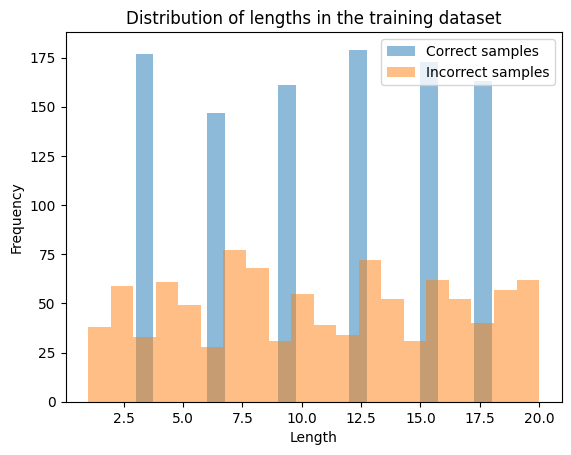

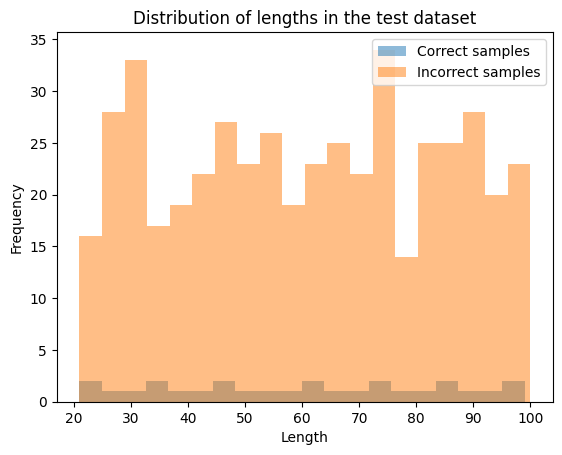

In [239]:
## Create the training dataset and use it for all models
dataset = create_dataset(1000, max_length=20)
test_dataset_str = create_dataset(500, 100, 21)

# remove all duplicates in test dataset
test_dataset_str = list(set(test_dataset_str))

# With padding
train_dataset_padded = GrammarDataset(dataset, padding_length=20, add_padding=True)

# Without padding
train_dataset = GrammarDataset(dataset)

## Create test datasets with min length 21 and max length 100
test_dataset_padded = GrammarDataset(test_dataset_str, padding_length=100, add_padding=True)
test_dataset = GrammarDataset(test_dataset_str)

# Print average length of test dataset_str
print("Average length of test dataset_str: ", np.mean([len(sample[0]) for sample in test_dataset_str]))

# Plot the distribution of lengths in the training datasets with respect to the label of the samples
import matplotlib.pyplot as plt

lengths_correct = [len(sample[0]) for sample in dataset if sample[1] == 1]
lengths_incorrect = [len(sample[0]) for sample in dataset if sample[1] == 0]

plt.hist(lengths_correct, bins=20, alpha=0.5, label='Correct samples')
plt.hist(lengths_incorrect, bins=20, alpha=0.5, label='Incorrect samples')
plt.legend(loc='upper right')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of lengths in the training dataset')
plt.show()

# Plot same for test dataset
lengths_correct = [len(sample[0]) for sample in test_dataset_str if sample[1] == 1]
lengths_incorrect = [len(sample[0]) for sample in test_dataset_str if sample[1] == 0]

plt.hist(lengths_correct, bins=20, alpha=0.5, label='Correct samples')
plt.hist(lengths_incorrect, bins=20, alpha=0.5, label='Incorrect samples')
plt.legend(loc='upper right')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of lengths in the test dataset')
plt.show()


    


## Main Routine for RNN

Hidden size: 4, Learning rate: 0.01, Num layers: 1
Epoch [1/10], Loss: 0.3175070427330211
Epoch [2/10], Loss: 0.39633740903425496
Epoch [3/10], Loss: 0.2517253239583806
Epoch [4/10], Loss: 0.20217867123219185
Epoch [5/10], Loss: 0.2324311192248133
Epoch [6/10], Loss: 0.2872641278840892
Epoch [7/10], Loss: 0.2553130331552602
Epoch [8/10], Loss: 0.12143371351611086
Epoch [9/10], Loss: 0.28654428606448257
Epoch [10/10], Loss: 0.34006302756968354
Accuracy: 73.99%
F1 score: 0.21
Input: abbc, Predicted: 0.08110463619232178


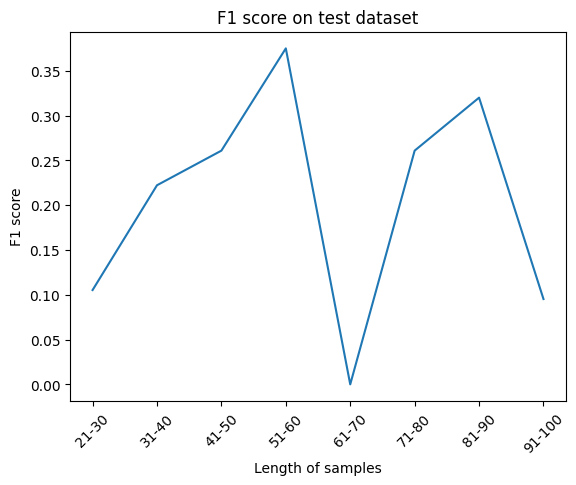

-------------------------------------
Hidden size: 4, Learning rate: 0.01, Num layers: 2
Epoch [1/10], Loss: 0.34303137953719126
Epoch [2/10], Loss: 0.25850394924799913
Epoch [3/10], Loss: 0.21381977835908764
Epoch [4/10], Loss: 0.14973695500358009
Epoch [5/10], Loss: 0.1384494450042257
Epoch [6/10], Loss: 0.16482135235558962
Epoch [7/10], Loss: 0.18702829502616078
Epoch [8/10], Loss: 0.3661122591055464
Epoch [9/10], Loss: 0.6128728836812078
Epoch [10/10], Loss: 0.47216308197844775
Accuracy: 88.10%
F1 score: 0.48
Input: abbc, Predicted: 0.053631771355867386


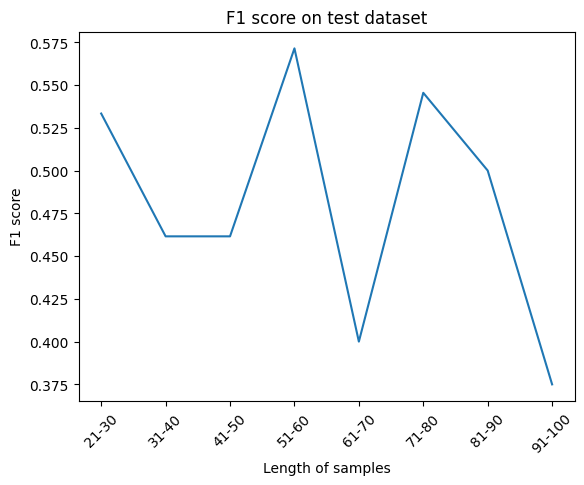

-------------------------------------
Hidden size: 4, Learning rate: 0.001, Num layers: 1
Epoch [1/10], Loss: 0.5794263842180372
Epoch [2/10], Loss: 0.34515295405499635
Epoch [3/10], Loss: 0.278838909516111
Epoch [4/10], Loss: 0.2570813345941715
Epoch [5/10], Loss: 0.24550083229644223
Epoch [6/10], Loss: 0.24047289694985374
Epoch [7/10], Loss: 0.23559160945354962
Epoch [8/10], Loss: 0.22932455536455382
Epoch [9/10], Loss: 0.22379923981358296
Epoch [10/10], Loss: 0.21950792563904542
Accuracy: 86.49%
F1 score: 0.45
Input: abbc, Predicted: 0.0065928129479289055


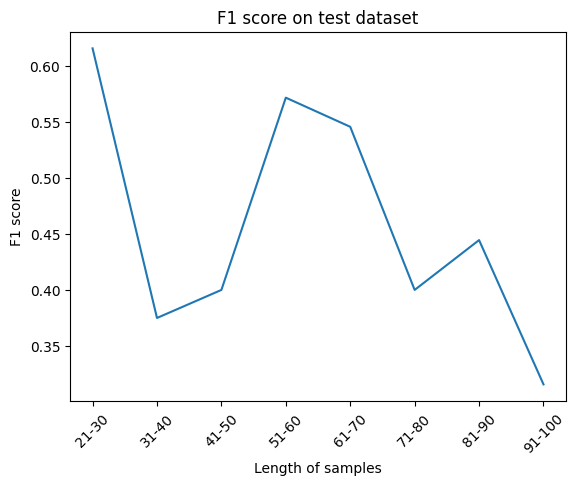

-------------------------------------
Hidden size: 4, Learning rate: 0.001, Num layers: 2
Epoch [1/10], Loss: 0.5779420183300972
Epoch [2/10], Loss: 0.44970981020480394
Epoch [3/10], Loss: 0.38492512820567937
Epoch [4/10], Loss: 0.2673697057296522
Epoch [5/10], Loss: 0.2500389118639287
Epoch [6/10], Loss: 0.23436627456569112
Epoch [7/10], Loss: 0.22076787601143588
Epoch [8/10], Loss: 0.2033977396923583
Epoch [9/10], Loss: 0.1958387226529303
Epoch [10/10], Loss: 0.17869987681190833
Accuracy: 86.69%
F1 score: 0.40
Input: abbc, Predicted: 0.0011548800393939018


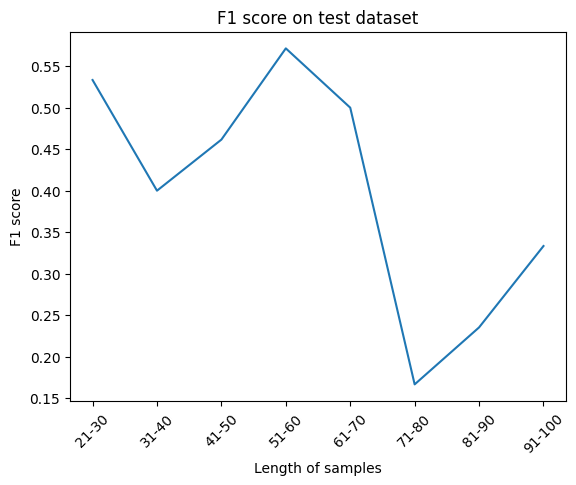

-------------------------------------
Hidden size: 8, Learning rate: 0.01, Num layers: 1
Epoch [1/10], Loss: 0.3366034365907544
Epoch [2/10], Loss: 0.26456940011528784
Epoch [3/10], Loss: 0.3110067279114737
Epoch [4/10], Loss: 0.25253301655188987
Epoch [5/10], Loss: 0.16405128743436945
Epoch [6/10], Loss: 0.13841000035530304
Epoch [7/10], Loss: 0.4062969309769105
Epoch [8/10], Loss: 0.374181285210012
Epoch [9/10], Loss: 0.37607612333330326
Epoch [10/10], Loss: 0.3631519698862976
Accuracy: 73.19%
F1 score: 0.29
Input: abbc, Predicted: 0.005595430266112089


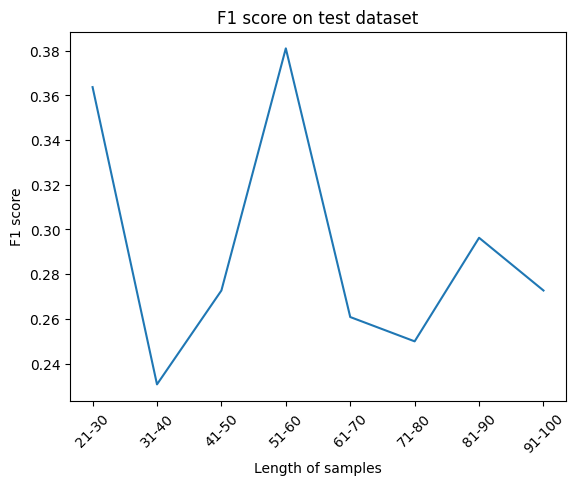

-------------------------------------
Hidden size: 8, Learning rate: 0.01, Num layers: 2
Epoch [1/10], Loss: 0.3328402458851924
Epoch [2/10], Loss: 0.2722439335437375
Epoch [3/10], Loss: 0.215226720331033
Epoch [4/10], Loss: 0.13135461218262937
Epoch [5/10], Loss: 0.1889665022262343
Epoch [6/10], Loss: 0.13284880722124126
Epoch [7/10], Loss: 0.11323786798615515
Epoch [8/10], Loss: 0.12858760011034792
Epoch [9/10], Loss: 0.1465971360083986
Epoch [10/10], Loss: 0.30161624932081466
Accuracy: 94.35%
F1 score: 0.66
Input: abbc, Predicted: 0.04553404450416565


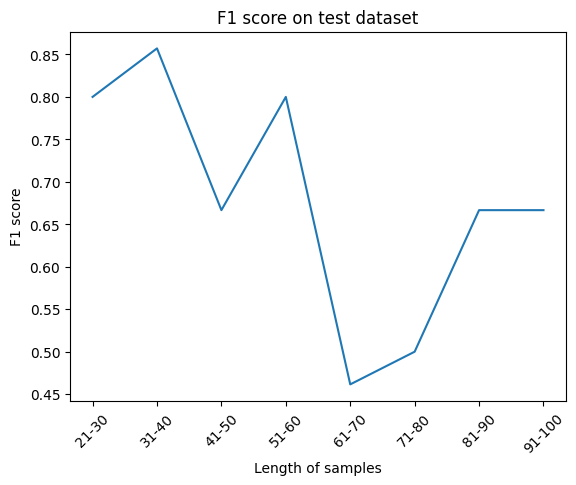

-------------------------------------
Hidden size: 8, Learning rate: 0.001, Num layers: 1
Epoch [1/10], Loss: 0.5449991555139423
Epoch [2/10], Loss: 0.4498465105262585
Epoch [3/10], Loss: 0.3478720770954387
Epoch [4/10], Loss: 0.23849053487420316
Epoch [5/10], Loss: 0.1923363142577
Epoch [6/10], Loss: 0.16352451847551855
Epoch [7/10], Loss: 0.1384083971765649
Epoch [8/10], Loss: 0.11709239200437878
Epoch [9/10], Loss: 0.10328124707815732
Epoch [10/10], Loss: 0.09543127850060046
Accuracy: 94.96%
F1 score: 0.19
Input: abbc, Predicted: 0.00029334824648685753


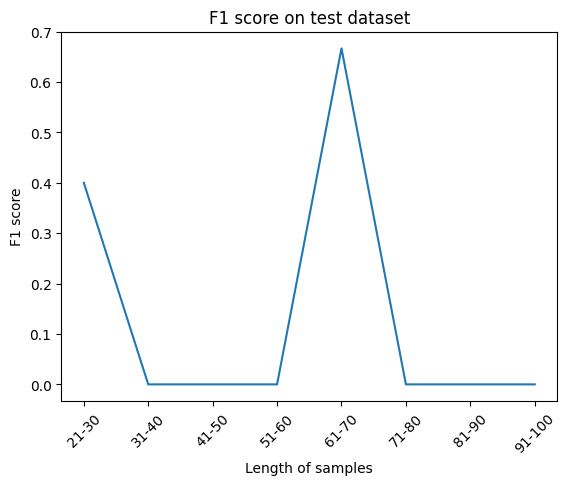

-------------------------------------
Hidden size: 8, Learning rate: 0.001, Num layers: 2
Epoch [1/10], Loss: 0.4254274371722713
Epoch [2/10], Loss: 0.2471039049550891
Epoch [3/10], Loss: 0.23035668911971152
Epoch [4/10], Loss: 0.20479978415579536
Epoch [5/10], Loss: 0.1722383609089884
Epoch [6/10], Loss: 0.10594771003141068
Epoch [7/10], Loss: 0.06613493205937265
Epoch [8/10], Loss: 0.0422428081343387
Epoch [9/10], Loss: 0.013608719998526794
Epoch [10/10], Loss: 0.023570716292433645
Accuracy: 93.75%
F1 score: 0.16
Input: abbc, Predicted: 7.358804577961564e-05


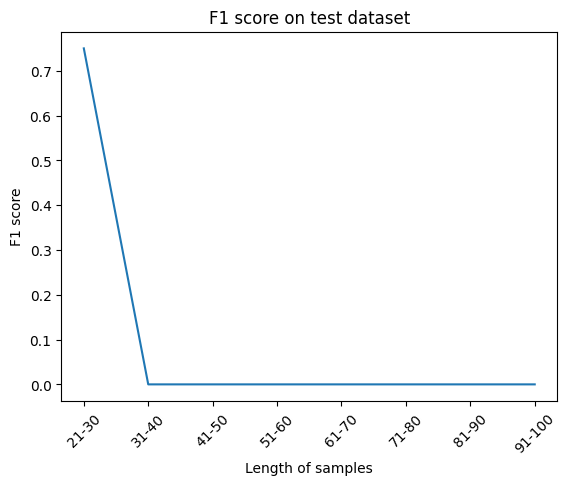

-------------------------------------
Hidden size: 16, Learning rate: 0.01, Num layers: 1
Epoch [1/10], Loss: 0.36732252221743694
Epoch [2/10], Loss: 0.09676193972973238
Epoch [3/10], Loss: 0.2920482520174594
Epoch [4/10], Loss: 0.25352955510472064
Epoch [5/10], Loss: 0.07806466474130934
Epoch [6/10], Loss: 0.04929937090526114
Epoch [7/10], Loss: 0.07964800840507938
Epoch [8/10], Loss: 0.3255789812614925
Epoch [9/10], Loss: 0.3275311119028107
Epoch [10/10], Loss: 0.3784855018747062
Accuracy: 65.32%
F1 score: 0.24
Input: abbc, Predicted: 0.051705531775951385


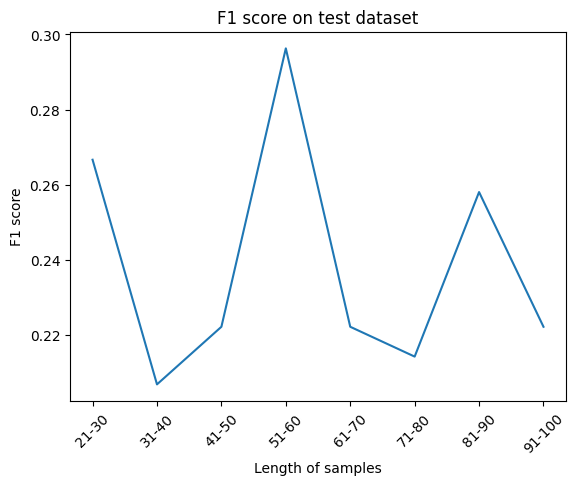

-------------------------------------
Hidden size: 16, Learning rate: 0.01, Num layers: 2
Epoch [1/10], Loss: 0.340175651979167
Epoch [2/10], Loss: 0.28484491725143746
Epoch [3/10], Loss: 0.2649661463404191
Epoch [4/10], Loss: 0.2503964704974496
Epoch [5/10], Loss: 0.30918651406690334
Epoch [6/10], Loss: 0.3103299347686243
Epoch [7/10], Loss: 0.33561136864343305
Epoch [8/10], Loss: 0.3880152655248512
Epoch [9/10], Loss: 0.42364907777423605
Epoch [10/10], Loss: 0.37709840910229653
Accuracy: 76.21%
F1 score: 0.31
Input: abbc, Predicted: 0.002691933186724782


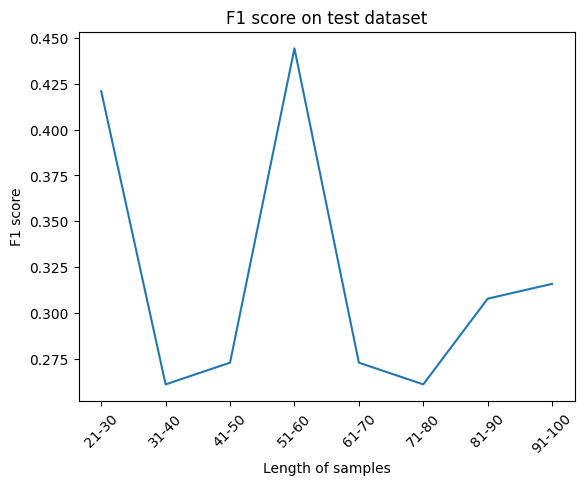

-------------------------------------
Hidden size: 16, Learning rate: 0.001, Num layers: 1
Epoch [1/10], Loss: 0.31048446287214754
Epoch [2/10], Loss: 0.08846238566120156
Epoch [3/10], Loss: 0.04495218486110389
Epoch [4/10], Loss: 0.046789000638604195
Epoch [5/10], Loss: 0.06219810318581676
Epoch [6/10], Loss: 0.026670205517511023
Epoch [7/10], Loss: 0.03186196167860408
Epoch [8/10], Loss: 0.019885324563080075
Epoch [9/10], Loss: 0.011872133709529293
Epoch [10/10], Loss: 0.01351837032259988
Accuracy: 95.36%
F1 score: 0.26
Input: abbc, Predicted: 2.122990736097563e-05


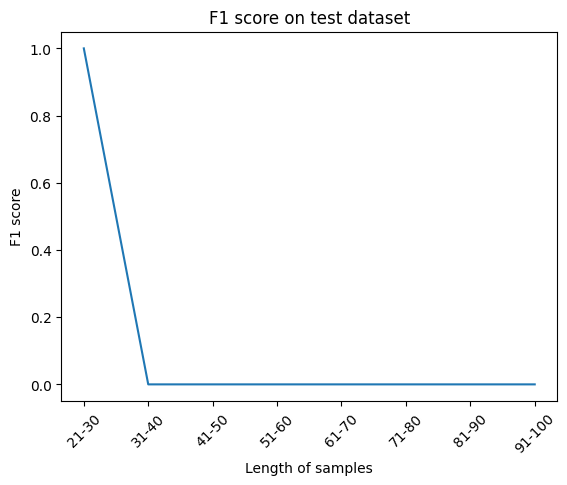

-------------------------------------
Hidden size: 16, Learning rate: 0.001, Num layers: 2
Epoch [1/10], Loss: 0.37236004215432333
Epoch [2/10], Loss: 0.1533036375763768
Epoch [3/10], Loss: 0.03855803698839009
Epoch [4/10], Loss: 0.03754000055207507
Epoch [5/10], Loss: 0.020998854506398858
Epoch [6/10], Loss: 0.006093573067206762
Epoch [7/10], Loss: 0.01135693173230493
Epoch [8/10], Loss: 0.0036767201600023326
Epoch [9/10], Loss: 0.009362302728135092
Epoch [10/10], Loss: 0.005923762487005888
Accuracy: 94.76%
F1 score: 0.46
Input: abbc, Predicted: 3.595084126573056e-05


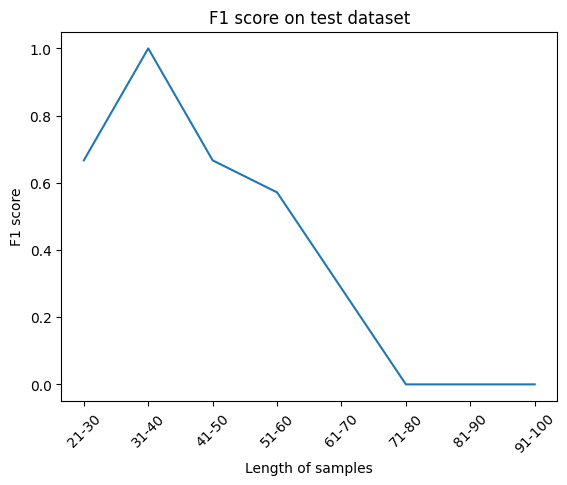

-------------------------------------
{'Hidden size: 8, Learning rate: 0.01, Num layers: 2': 0.6585365853658536, 'Hidden size: 4, Learning rate: 0.01, Num layers: 2': 0.47787610619469023, 'Hidden size: 16, Learning rate: 0.001, Num layers: 2': 0.4583333333333333, 'Hidden size: 4, Learning rate: 0.001, Num layers: 1': 0.44628099173553726, 'Hidden size: 4, Learning rate: 0.001, Num layers: 2': 0.4, 'Hidden size: 16, Learning rate: 0.01, Num layers: 2': 0.3139534883720931, 'Hidden size: 8, Learning rate: 0.01, Num layers: 1': 0.2887700534759359, 'Hidden size: 16, Learning rate: 0.001, Num layers: 1': 0.25806451612903225, 'Hidden size: 16, Learning rate: 0.01, Num layers: 1': 0.23893805309734514, 'Hidden size: 4, Learning rate: 0.01, Num layers: 1': 0.2085889570552147, 'Hidden size: 8, Learning rate: 0.001, Num layers: 1': 0.19354838709677416, 'Hidden size: 8, Learning rate: 0.001, Num layers: 2': 0.16216216216216217}


In [240]:
# Cross-Validation for Hyperparameters
hidden_sizes = [4, 8, 16]
output_size = 1
num_epochs = 10
learning_rates = [0.01, 0.001]
num_layers = [1, 2]

# Run without padding
add_padding = False
sequence_length = 1
input_size = 3

f1_results = {}

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for num_layer in num_layers:
            print(f'Hidden size: {hidden_size}, Learning rate: {learning_rate}, Num layers: {num_layer}')
            model = RNNClassifier(input_size, hidden_size, output_size, num_layers=num_layer)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            train_model(model, criterion, optimizer, num_epochs, train_dataset, sequence_length)    
            accuracy, f1 = evaluate(model, test_dataset, sequence_length)
            print(f'Accuracy: {accuracy * 100:.2f}%')
            print(f'F1 score: {f1:.2f}')
            
            dict_string = f'Hidden size: {hidden_size}, Learning rate: {learning_rate}, Num layers: {num_layer}'
            f1_results[dict_string] = f1
        
            model.eval()
            with torch.no_grad():
                # Test 'abbc' as input
                inputs = string_to_tensor('abbc')
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                predicted = outputs
                inputs_str = ''.join(['a' if c[0] == 1 else 'b' if c[1] == 1 else 'c' if c[2] == 1 else '' for c in inputs[0]])
                print(f'Input: {inputs_str}, Predicted: {predicted.item()}')

            # Split test dataset into bins of length 21-30, 31-40, ... and evaluate the model on each bin (only f1). Then plot the results in a line chart.
            bins = [(i, i+9) for i in range(21, 101, 10)]
            f1_scores = []
            for bin in bins:
                bin_dataset = [sample for sample in test_dataset_str if len(sample[0]) >= bin[0] and len(sample[0]) <= bin[1]]
                bin_dataset = GrammarDataset(bin_dataset)
                f1_scores.append(evaluate(model, bin_dataset, sequence_length)[1])
                
            plt.plot([f'{bin[0]}-{bin[1]}' for bin in bins], f1_scores)
            plt.xlabel('Length of samples')
            plt.ylabel('F1 score')
            plt.title('F1 score on test dataset')
            plt.xticks(rotation=45)
            plt.show()
            
            print('-------------------------------------')


# sort f1 results descending by f1 score
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))
print(f1_results)

## LSTM Model

In [241]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take the last time step's output
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    
print(LSTMClassifier(3, 10, 1))


LSTMClassifier(
  (lstm): LSTM(3, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Main Routine for LSTM model

Hidden size: 4, Learning rate: 0.01, Num layers: 1
Epoch [1/10], Loss: 0.43052888472902123
Epoch [2/10], Loss: 0.3324770078379806
Epoch [3/10], Loss: 0.27745795285068564
Epoch [4/10], Loss: 0.2536669073448538
Epoch [5/10], Loss: 0.550293023833718
Epoch [6/10], Loss: 0.3215676662797341
Epoch [7/10], Loss: 0.2755337949036184
Epoch [8/10], Loss: 0.2601252397019198
Epoch [9/10], Loss: 0.2729916825626133
Epoch [10/10], Loss: 0.2554062275405813
Accuracy: 78.43%
F1 score: 0.34


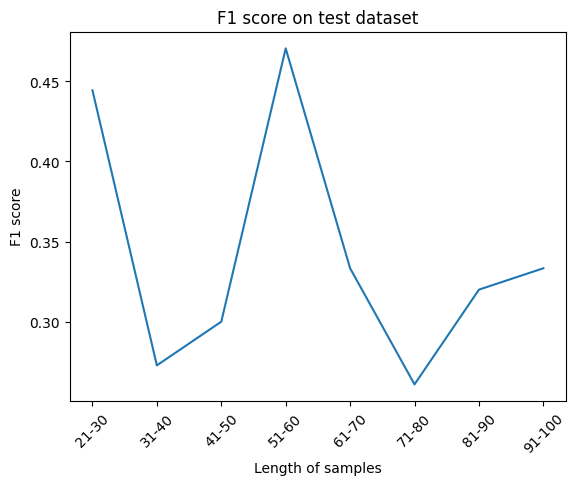

-------------------------------------
Hidden size: 4, Learning rate: 0.01, Num layers: 2
Epoch [1/10], Loss: 0.39889890095184094
Epoch [2/10], Loss: 0.21207616609570687
Epoch [3/10], Loss: 0.1642904405501613
Epoch [4/10], Loss: 0.17302013398911367
Epoch [5/10], Loss: 0.01630196742361477
Epoch [6/10], Loss: 0.05981648563137423
Epoch [7/10], Loss: 0.0029037208279781906
Epoch [8/10], Loss: 0.00048757188050046807
Epoch [9/10], Loss: 0.24796824988869776
Epoch [10/10], Loss: 0.2635668691026888
Accuracy: 88.91%
F1 score: 0.50


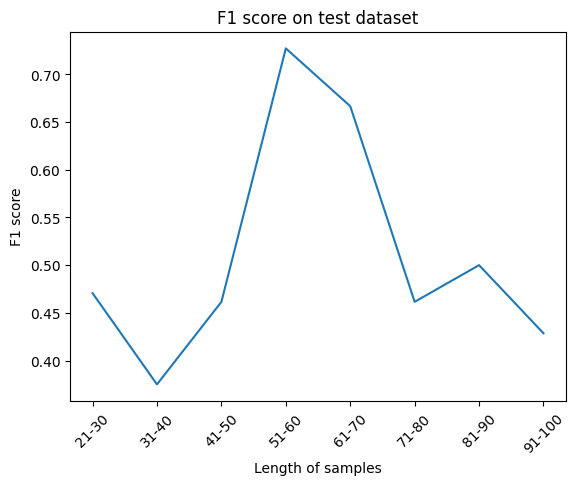

-------------------------------------
Hidden size: 4, Learning rate: 0.001, Num layers: 1
Epoch [1/10], Loss: 0.5795615512058139
Epoch [2/10], Loss: 0.3954289886448532
Epoch [3/10], Loss: 0.3511421737521887
Epoch [4/10], Loss: 0.3288937969491817
Epoch [5/10], Loss: 0.3129412105730735
Epoch [6/10], Loss: 0.3034765065128449
Epoch [7/10], Loss: 0.2937024135903921
Epoch [8/10], Loss: 0.287828617808409
Epoch [9/10], Loss: 0.28194180491147564
Epoch [10/10], Loss: 0.2789899132132996
Accuracy: 94.56%
F1 score: 0.00


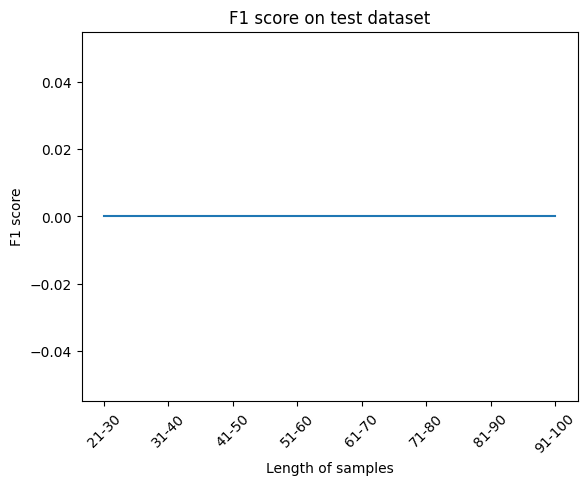

-------------------------------------
Hidden size: 4, Learning rate: 0.001, Num layers: 2
Epoch [1/10], Loss: 0.5871864524334669
Epoch [2/10], Loss: 0.39309310997277497
Epoch [3/10], Loss: 0.3343789028311148
Epoch [4/10], Loss: 0.29422480988223104
Epoch [5/10], Loss: 0.27610372101608666
Epoch [6/10], Loss: 0.22018724779016338
Epoch [7/10], Loss: 0.2146471016870346
Epoch [8/10], Loss: 0.16972326355031692
Epoch [9/10], Loss: 0.14563102939090458
Epoch [10/10], Loss: 0.11561274155491265
Accuracy: 94.56%
F1 score: 0.00


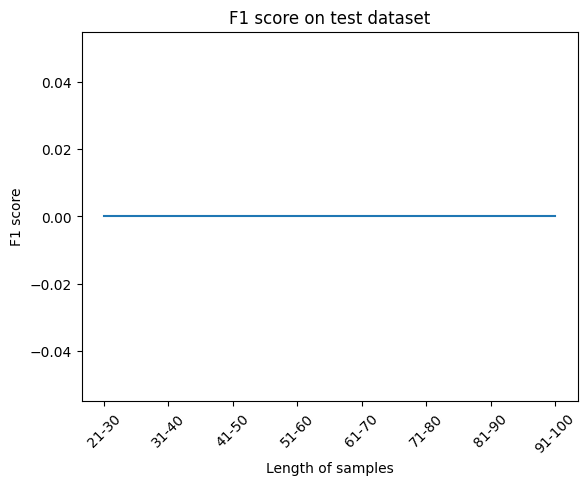

-------------------------------------
Hidden size: 8, Learning rate: 0.01, Num layers: 1
Epoch [1/10], Loss: 0.38571219842368737
Epoch [2/10], Loss: 0.17033841018279783
Epoch [3/10], Loss: 0.047507186083843404
Epoch [4/10], Loss: 0.10603767430855442
Epoch [5/10], Loss: 0.10193717496516047
Epoch [6/10], Loss: 0.10889657580647054
Epoch [7/10], Loss: 0.09063933442067537
Epoch [8/10], Loss: 0.0551645578181442
Epoch [9/10], Loss: 0.09436295794100806
Epoch [10/10], Loss: 0.06957631852018241
Accuracy: 88.10%
F1 score: 0.44


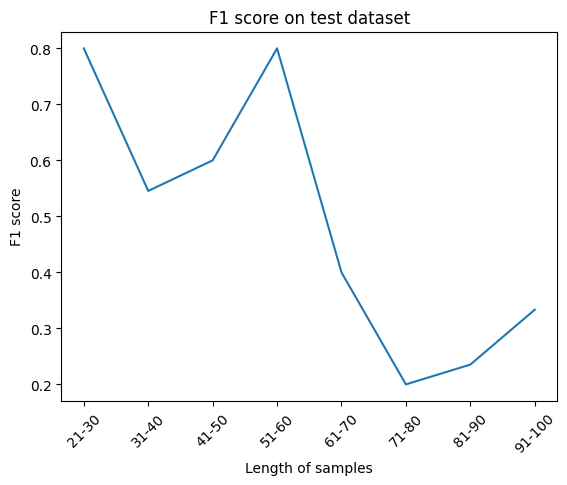

-------------------------------------
Hidden size: 8, Learning rate: 0.01, Num layers: 2
Epoch [1/10], Loss: 0.4009796774018178
Epoch [2/10], Loss: 0.2745323223546584
Epoch [3/10], Loss: 0.20665550978131614
Epoch [4/10], Loss: 0.20700036377223296
Epoch [5/10], Loss: 0.18265144235606157
Epoch [6/10], Loss: 0.12374194990592127
Epoch [7/10], Loss: 0.10055986760201699
Epoch [8/10], Loss: 0.07723612409996668
Epoch [9/10], Loss: 0.0782959880285775
Epoch [10/10], Loss: 0.01640419562870066
Accuracy: 94.15%
F1 score: 0.33


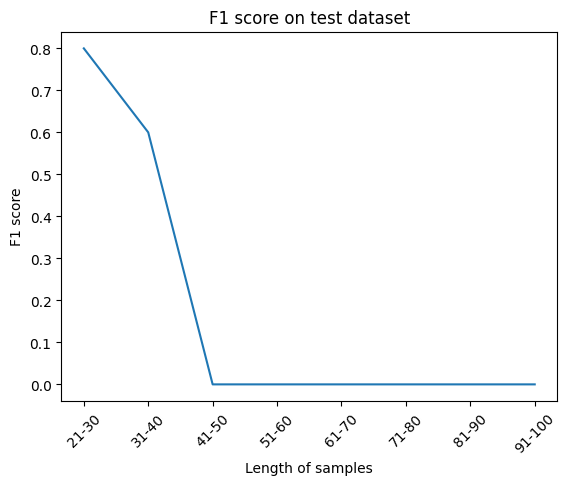

-------------------------------------
Hidden size: 8, Learning rate: 0.001, Num layers: 1
Epoch [1/10], Loss: 0.5476609083367512
Epoch [2/10], Loss: 0.40484475177770946
Epoch [3/10], Loss: 0.3377658754719305
Epoch [4/10], Loss: 0.28405386700766394
Epoch [5/10], Loss: 0.2564051162603428
Epoch [6/10], Loss: 0.2277145238971789
Epoch [7/10], Loss: 0.18580598186343195
Epoch [8/10], Loss: 0.1477957705634244
Epoch [9/10], Loss: 0.12555171615936023
Epoch [10/10], Loss: 0.11970763548789728
Accuracy: 94.56%
F1 score: 0.00


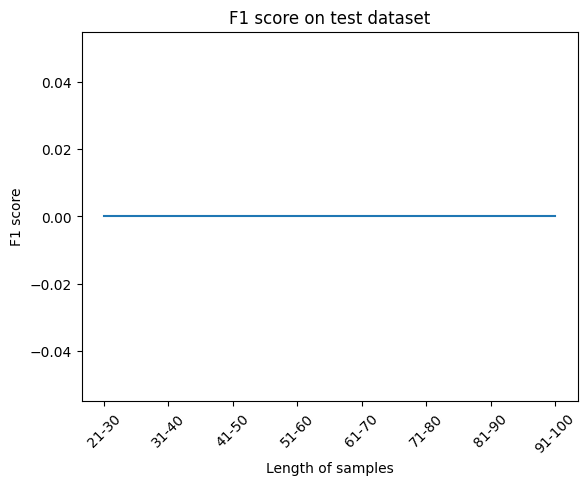

-------------------------------------
Hidden size: 8, Learning rate: 0.001, Num layers: 2
Epoch [1/10], Loss: 0.5140241647809743
Epoch [2/10], Loss: 0.3546910404327791
Epoch [3/10], Loss: 0.28068735381925947
Epoch [4/10], Loss: 0.21298452523164452
Epoch [5/10], Loss: 0.15488872346904828
Epoch [6/10], Loss: 0.10728480205590313
Epoch [7/10], Loss: 0.08165117162964271
Epoch [8/10], Loss: 0.07749157664068115
Epoch [9/10], Loss: 0.0726943684163898
Epoch [10/10], Loss: 0.04049128524542448
Accuracy: 94.76%
F1 score: 0.07


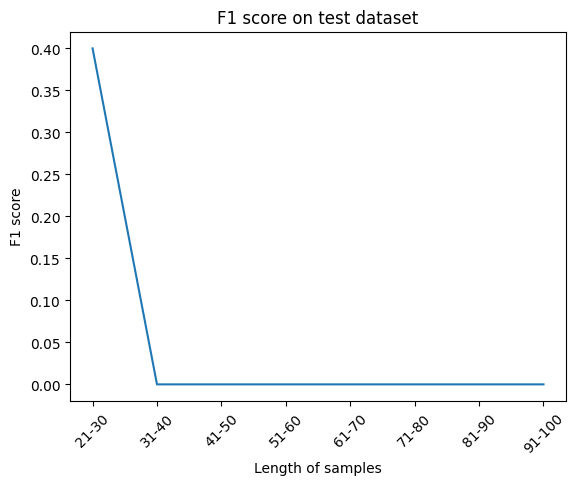

-------------------------------------
Hidden size: 16, Learning rate: 0.01, Num layers: 1
Epoch [1/10], Loss: 0.2709073802784187
Epoch [2/10], Loss: 0.11964135605538787
Epoch [3/10], Loss: 0.0388035384471078
Epoch [4/10], Loss: 0.02536567944603309
Epoch [5/10], Loss: 0.14702356417681478
Epoch [6/10], Loss: 0.024646694038197442
Epoch [7/10], Loss: 0.006157933523094014
Epoch [8/10], Loss: 0.0008271939045277425
Epoch [9/10], Loss: 0.0002992441763153031
Epoch [10/10], Loss: 0.04156423454159171
Accuracy: 96.57%
F1 score: 0.71


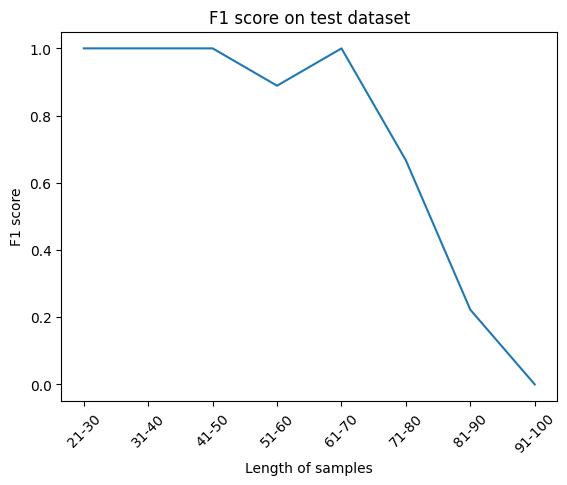

-------------------------------------
Hidden size: 16, Learning rate: 0.01, Num layers: 2
Epoch [1/10], Loss: 0.3251230478355428
Epoch [2/10], Loss: 0.15783632544591092
Epoch [3/10], Loss: 0.08683736263955506
Epoch [4/10], Loss: 0.08257799403133595
Epoch [5/10], Loss: 0.013163681418749093
Epoch [6/10], Loss: 0.0006514314405397385
Epoch [7/10], Loss: 0.00014996871305893934
Epoch [8/10], Loss: 4.10640012172081e-05
Epoch [9/10], Loss: 1.0707302792328121e-05
Epoch [10/10], Loss: 3.587897125451045e-06
Accuracy: 99.80%
F1 score: 0.98


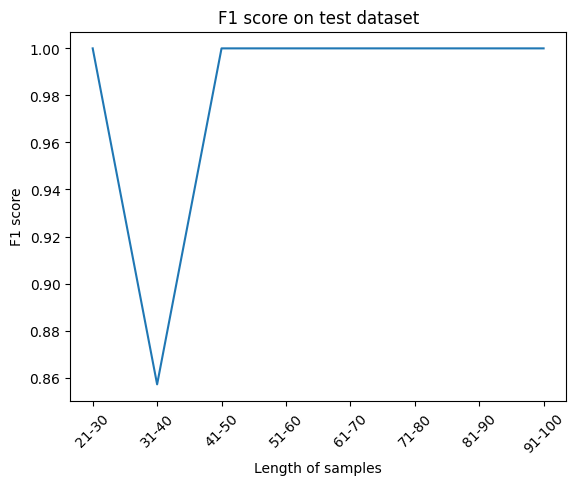

-------------------------------------
Hidden size: 16, Learning rate: 0.001, Num layers: 1
Epoch [1/10], Loss: 0.48943675082875415
Epoch [2/10], Loss: 0.3718084705211222
Epoch [3/10], Loss: 0.33044969608058455
Epoch [4/10], Loss: 0.3201106998057221
Epoch [5/10], Loss: 0.2834726266037906
Epoch [6/10], Loss: 0.25334404709300723
Epoch [7/10], Loss: 0.22633085128954464
Epoch [8/10], Loss: 0.18789965387327037
Epoch [9/10], Loss: 0.15597433156635587
Epoch [10/10], Loss: 0.11807362268981046
Accuracy: 94.76%
F1 score: 0.07


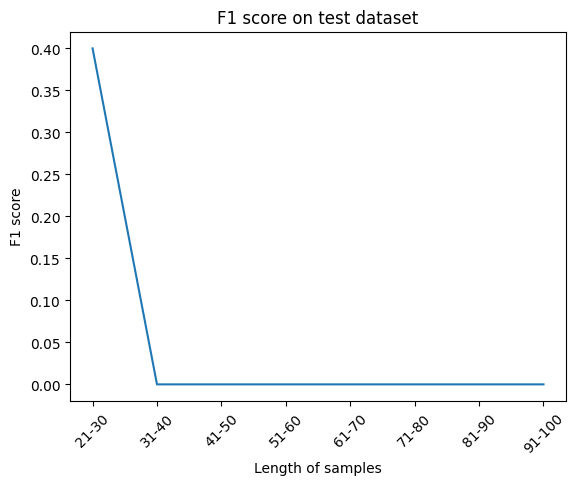

-------------------------------------
Hidden size: 16, Learning rate: 0.001, Num layers: 2
Epoch [1/10], Loss: 0.4840532096745446
Epoch [2/10], Loss: 0.3610512883255142
Epoch [3/10], Loss: 0.29040001256763937
Epoch [4/10], Loss: 0.22954627689557675
Epoch [5/10], Loss: 0.17707728303120893
Epoch [6/10], Loss: 0.1761936249859973
Epoch [7/10], Loss: 0.10797679419067072
Epoch [8/10], Loss: 0.10414855147233641
Epoch [9/10], Loss: 0.05584306601121455
Epoch [10/10], Loss: 0.056173389384663194
Accuracy: 93.95%
F1 score: 0.06


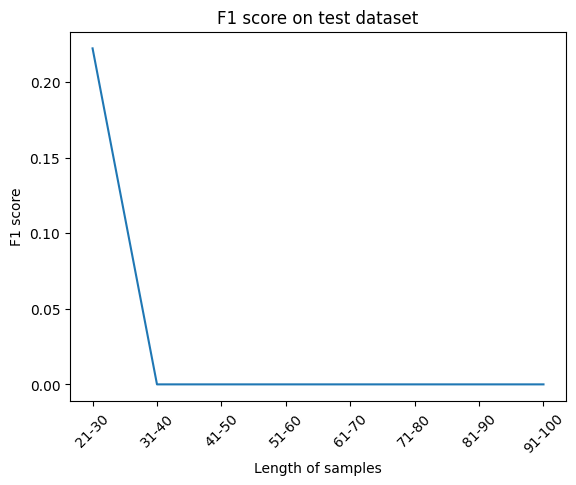

-------------------------------------
{'Hidden size: 16, Learning rate: 0.01, Num layers: 2': 0.9818181818181818, 'Hidden size: 16, Learning rate: 0.01, Num layers: 1': 0.711864406779661, 'Hidden size: 4, Learning rate: 0.01, Num layers: 2': 0.4954128440366972, 'Hidden size: 8, Learning rate: 0.01, Num layers: 1': 0.4380952380952381, 'Hidden size: 4, Learning rate: 0.01, Num layers: 1': 0.3354037267080745, 'Hidden size: 8, Learning rate: 0.01, Num layers: 2': 0.3255813953488372, 'Hidden size: 8, Learning rate: 0.001, Num layers: 2': 0.07142857142857142, 'Hidden size: 16, Learning rate: 0.001, Num layers: 1': 0.07142857142857142, 'Hidden size: 16, Learning rate: 0.001, Num layers: 2': 0.0625, 'Hidden size: 4, Learning rate: 0.001, Num layers: 1': 0, 'Hidden size: 4, Learning rate: 0.001, Num layers: 2': 0, 'Hidden size: 8, Learning rate: 0.001, Num layers: 1': 0}


In [242]:
# Hyperparameters for LSTM
hidden_size = [4, 8, 16]
output_size = 1
num_epochs = 10
learning_rate = [0.01, 0.001]
num_layers = [1, 2]


# Without Padding
add_padding = False
sequence_length = 1
input_size = 3


f1_results = {}

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for num_layer in num_layers:
            print(f'Hidden size: {hidden_size}, Learning rate: {learning_rate}, Num layers: {num_layer}')

            model = LSTMClassifier(input_size, hidden_size, output_size, num_layers=num_layer)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training loop
            train_model(model, criterion, optimizer, num_epochs, train_dataset, sequence_length)
            accuracy, f1 = evaluate(model, test_dataset, sequence_length)
            print(f'Accuracy: {accuracy * 100:.2f}%')
            print(f'F1 score: {f1:.2f}')
            dict_string = f'Hidden size: {hidden_size}, Learning rate: {learning_rate}, Num layers: {num_layer}'
            f1_results[dict_string] = f1
            model.eval()
                    
            # Split test dataset into bins of length 21-25, 26-30, ... and evaluate the model on each bin (only f1). 
            # Then plot the results in a line chart.
            f1_scores = []
            for bin in bins:
                bin_dataset = [sample for sample in test_dataset_str if len(sample[0]) >= bin[0] and len(sample[0]) <= bin[1]]
                bin_dataset = GrammarDataset(bin_dataset)
                f1_scores.append(evaluate(model, bin_dataset, sequence_length)[1])
                
            plt.plot([f'{bin[0]}-{bin[1]}' for bin in bins], f1_scores)
            plt.xlabel('Length of samples')
            plt.ylabel('F1 score')
            plt.title('F1 score on test dataset')
            plt.xticks(rotation=45)
            plt.show()
            
            print('-------------------------------------')
            
## Print the f1 scores sorted by the best f1 score
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))   
print(f1_results)
        